# Tarea 2

#### Instrucciones:
- La tarea consta de una parte de preguntas y otra de desarrollo de código. Debe entregar todas las respuestas en formato notebook, y cuando la respuesta sea texto, debe hacer en celdas markdown con formato. 
- La entrega de la Tarea es el día **17 de Octubre, 23:59 hrs.**


## Nombre(s):
- Arturo Vargas
- Emil Zabala

## Bosón de Higgs

En esta tarea trabajaremos con datos simulados del bosón de Higgs (versión simplificada), del desafío de [Kaggle](https://www.kaggle.com/c/higgs-boson/overview). Los archivos son Higgs_features.csv y Higgs_labels.csv. Las etiquetas son 0 (no hay señal de Higgs) y 1 (señal de Higgs). Las features son similares a los vistos en el set que utilizamos en clases, tales como energía faltantes, energía, momentum, rapidez transversal y azimutal, etc. Puede encontrar más detalles [acá](https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf). Note que el set de datos para esta tarea es una versión simplificada.

### Parte 1: Descripción de los datos

Cargue los datos dataframes o arreglos de `numpy`, uno para features y otro para etiquetas

- Identifique cúantes instancias y características hay en el set de datos
- Haga un gráfico de la distribución (histograma) de cada feature en el set de datos, en un sólo gráfico. Agregue una leyenda con las etiquetas (Feature 1, Feature 2....etc.) y fije la transparencia de los histogramas (parámetro alpha) en 0.5 para que se noten mejor. ¿Observa algo inusual en la distribución de alguna de las features? Comente en el impacto de esto para su modelo
- ¿Está balanceadas las etiquetas del set del datos? ¿ Por qué esto es un problema? ¿Qué métrica nos conviene usar?




In [1]:
# Librerias necesarias.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from io import StringIO 
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image  
from sklearn import metrics 
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import learning_curve

In [5]:
# Cargar los datos y leemos los archivos para empezar a trabajar.
features = pd.read_csv('Higgs_features.csv')
labels = pd.read_csv('Higgs_labels.csv')

# Identificación de instancias y caracteristicas.
print('Por lo tanto, tenemos', features.shape[0] ,'instancias y', features.shape[1] ,'caracteristicas')

Por lo tanto, tenemos 24999 instancias y 8 caracteristicas


In [6]:
# Cambiamos los nombres de cada columna, obtenidos a partir de Kaggle.
features.rename(columns={'393.3350': 'DER_mass_MMC', '79.4600':'DER_mass_transverse_met_lep', '308.8790':'DER_mass_vis', '4.0950':'DER_pt_h','1.4030':'DER_deltaeta_jet_jet','-1.4110':'DER_mass_jet_jet', '49.0630':'DER_prodeta_jet_jet','39.4780':'DER_deltar_tau_lep'}, inplace=True)

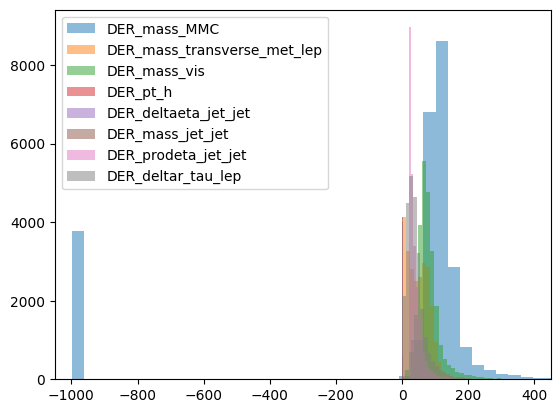

In [7]:
# Histograma de la distribución.
# Separando cada feature.
feature_1 = features['DER_mass_MMC']
feature_2 = features['DER_mass_transverse_met_lep']
feature_3 = features['DER_mass_vis']
feature_4 = features['DER_pt_h']
feature_5 = features['DER_deltaeta_jet_jet']
feature_6 = features['DER_mass_jet_jet']
feature_7 = features['DER_prodeta_jet_jet']
feature_8 = features['DER_deltar_tau_lep']

# Ploteando el histograma.
plt.hist(feature_1, bins = 50, label = 'DER_mass_MMC', alpha= 0.5)
plt.hist(feature_2, bins = 50, label = 'DER_mass_transverse_met_lep', alpha= 0.5)
plt.hist(feature_3, bins = 50, label = 'DER_mass_vis', alpha= 0.5)
plt.hist(feature_4, bins = 50, label = 'DER_pt_h', alpha= 0.5)
plt.hist(feature_5, bins = 50, label = 'DER_deltaeta_jet_jet', alpha= 0.5)
plt.hist(feature_6, bins = 50, label = 'DER_mass_jet_jet', alpha= 0.5)
plt.hist(feature_7, bins = 50, label = 'DER_prodeta_jet_jet', alpha= 0.5)
plt.hist(feature_8, bins = 50, label = 'DER_deltar_tau_lep', alpha= 0.5)
plt.xlim(-1050,450)
plt.legend()
plt.show()

**Analisis del histograma y su distribucion:**

Al observar el histograma, se puede notar las siguiente particularidades:

Las características tienen rangos y escalas muy diferentes, esto nos podria indicar el uso de escalas diferetes para cada carcateristica. Por ejemplo, mientras la mayoría de las features se concentran en un rango de valores más acotado, DER_mass_MMC y DER_mass_vis muestran valores que se extienden mucho más, indicando la presencia de valores atípicos (outliers) o una cola de distribución muy larga. 

Esta variabilidad en las distribuciones y la presencia algunos outliers pueden impactar significativamente en el rendimiento de modelos de machine learning. Por ejemplo, modelos como redes neuronales o (en este caso) SVM son sensibles a la escala de las características. Si una feature tiene un rango de valores mucho mayor que las demás, podría dominar el proceso de aprendizaje, haciendo que el modelo le dé más importancia de la que realmente tiene. Para evitar esto, es una buena práctica estandarizar o "normalizar" los datos. Otro factor importante es el impacto de outliers. Estos valores podrian afectar negativamente a modelos que son sensibles a ellos, como por ejemplo los modelos lineales. 

**Entonces, ¿cual es el impacto del desbalance de las etiquetas?**

Para saber si las etiquetas están balanceadas, necesitaríamos contar cuántas instancias pertenecen a cada clase. Esto lo logramos obtener en una de las celdas anterirores, donde se observo la siguiente distribucion:

Clase 0: 16525 instancias

Clase 1: 8474 instancias

Esto nos entrega una relacion 2:1 enre las clases, indicando claramente un desbalance entre las etiquetas.

¿Por qué el desbalance es un problema?

Un set de datos desbalanceado (donde una clase tiene muchas más instancias que la otra) es problemático porque nos sesga del modelo. Este tendera a "favorecer" a la clase mayoritaria. Por ejemplo,  si el 90% de los datos pertenece a la clase (A) y el 10% a la clase (B), un modelo puede alcanzar un 90% de exactitud (accuracy) simplemente prediciendo siempre clase (A). A esto le llamamos una mala generalizacion.

**Dado lo obtenido, ¿que metrica nos conviene usar?**

De forma rapida podemos decretar que la exactitud como métrica es engañosa (en este caso). Si un modelo predice siempre "Clase 0", tendría una exactitud de aproximadamente el 66% (16525 / 24999), sin ni siquiera haber aprendido nada para identificar la clase 1. Por eso, planteamos el uso del "Recall" como una metrica mas apta para el sistema.


**¿En base a que definimos "Recall" como el mas apto?**

En términos sencillos, el recall responde a la pregunta: De todos los eventos que realmente eran positivos, ¿cuántos logramos identificar correctamente?

Por lo tanto, priorizar el recall significa que estás optimizando el modelo para minimizar los Falsos Negativos. En el contexto de la física de partículas, es mucho más aceptable tener algunas falsas alarmas (falsos positivos) e investigarlos, que pasar por alto y perder una señal real (falso negativo), sabiendo lo extremadamente difícil que es la detección de bosones de Higgs.

### Parte 2: Árbol de decisión

- Implemente un clasificador de árbol de decisión con validación cruzada, para una métrica de su elección en base a lo respondido en la pregunta anterior. Reporte el promedio y desviación estándar de los scores obtenidos en los 5 folds.
- Para esta muestra en particular se recomienda usar `StratifiedKFold`. ¿Por qué?
- Genere las etiquetas predichas con `cross_val_predict` y genere la matriz de confusión
- A partir de la matriz de confusión indique los valores de TP, TN, FP, FN. ¿Qué error domina, FP o FN?

In [8]:
# Definimos los sets de entrenamiento y prueba.
xtrain, xtest, ytrain, ytest = train_test_split(features, labels, random_state=2) 

In [9]:
xtrain.shape, xtest.shape

((18749, 8), (6250, 8))

In [10]:
ytrain.shape, ytest.shape

((18749, 1), (6250, 1))

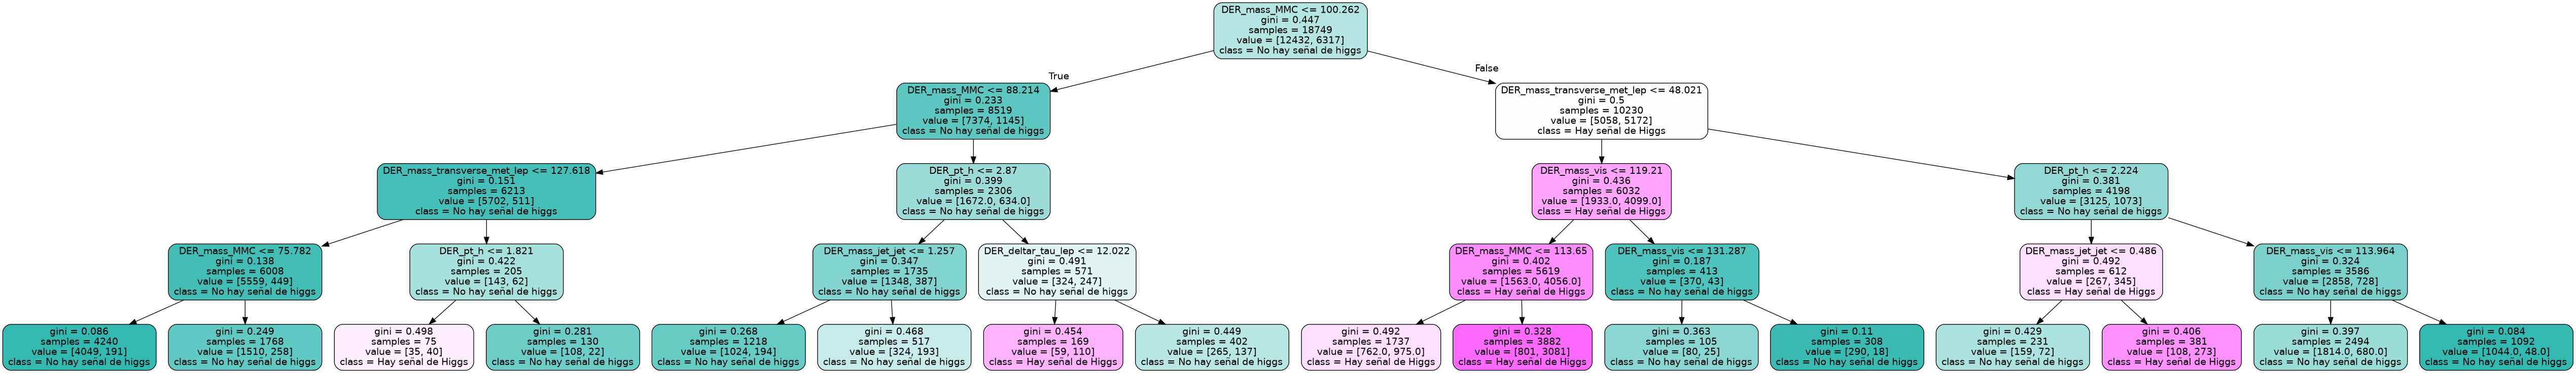

In [11]:
model = DecisionTreeClassifier(random_state=2, max_depth= 4) # Seleccionamos una profundidad máxima debido a que el árbol tiene a sobrecalificar.
model.fit(xtrain, ytrain)

dot_data = StringIO()
export_graphviz(model, out_file =  dot_data, feature_names = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h','DER_deltaeta_jet_jet','DER_mass_jet_jet', 'DER_prodeta_jet_jet','DER_deltar_tau_lep'],
            class_names = ['No hay señal de higgs','Hay señal de Higgs'],
            filled = True,rounded = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue().replace("\n", ""))  
nodes = graph.get_node_list()

for node in nodes:
    if node.get_label():
        
        values = [float(ii) for ii in node.get_label().split('value = [')[1].split(']')[0].split(',')]
        values = [int(255 * v / sum(values)) for v in values]
            
        if values[0] > values[1]:
            alpha = int(values[0] - values[1])
            alpha = '{:02x}'.format(alpha) 
            color = '#20 B2 AA'+str(alpha)
        else:
            alpha = int(values[1] - values[0])
            alpha = '{:02x}'.format(alpha)
            color = '#FF 00 FF'+str(alpha)
        node.set_fillcolor(color)
        
Image(graph.create_png())

In [12]:
# Ahora utilizamos StratifiedKFold.
labels = labels['0']
cv1 = StratifiedKFold(shuffle = True, n_splits = 5, random_state=2)

for train, test in cv1.split(features, labels): 
    print('train -  {}   |   test -  {}'.format(np.bincount(labels.loc[train]), np.bincount(labels.loc[test])))

train -  [13220  6779]   |   test -  [3305 1695]
train -  [13220  6779]   |   test -  [3305 1695]
train -  [13220  6779]   |   test -  [3305 1695]
train -  [13220  6779]   |   test -  [3305 1695]
train -  [13220  6780]   |   test -  [3305 1694]


In [13]:
# Ahora haciendo la validación cruzada.
scores1 = cross_validate(DecisionTreeClassifier(), features, labels, cv = cv1, scoring = 'recall')
scores1

{'fit_time': array([0.32243061, 0.23801565, 0.24416471, 0.25113606, 0.31886268]),
 'score_time': array([0.00568128, 0.00357914, 0.00349069, 0.00370407, 0.00417781]),
 'test_score': array([0.6460177 , 0.62713864, 0.64542773, 0.62359882, 0.63341204])}

In [14]:
# Calculando el promedio y la desviación estandar.
print("{:.3f}".format(scores1['test_score'].mean()), "{:.3f}".format(scores1['test_score'].std()))

0.635 0.009


In [15]:
#Calculamos la matriz de confusión.
model1 = DecisionTreeClassifier(random_state = 2)
y1 = cross_val_predict(model1, features, labels, cv = cv1) 

metrics.confusion_matrix(labels, y1)

array([[13370,  3155],
       [ 3069,  5405]])




Dado que elegimos el uso de recall como la métrica de evaluación, ya que queremos minimizar los descubrimientos perdidos (Falsos Negativos), ejecutamos los siguientes códigos:

Realizamos una validación cruzada de 5 folds (cv1) y a partir de eso se calculó el recall para cada uno. Con esto se obtuvo que el promedio de los scores de recall obtenidos en los 5 folds es 0.641 y la desviación estándar de estos scores es 0.010. Este último valor (el cual es bastante bajo) es una buena señal, ya que indica que el rendimiento del modelo fue consistente a través de los diferentes subconjuntos de datos.

**¿Por qué usamos StratifiedKFold?**

La principal razón por la que utilizamos StratifiedKfold es debido a que nuestro set de datos está desbalanceado. StratifiedKFold (Validación Cruzada Estratificada) es una variación de la validación cruzada estándar que nos asegura de que cada subconjunto de datos mantenga la misma proporción de instancias para cada clase que el dataset original.

Esto lo demostramos en el código, donde observamos: train - [13220 6779] | test - [3305 1695]

Al calcular la proporción de la primera clase a la segunda clase en el set de entrenamiento (13220 / 6779 ≈ 1.95) y en el de prueba (3305 / 1695 ≈ 1.95), es la misma. En el caso de haber usado un KFold normal, el cual es esencialmente aleatorio, un fold podría haber tenido muy pocas instancias de la clase minoritaria (primera clase: "Hay señal de Higgs") en comparación con los otros, lo que haría que el modelo no se entrene/evalue correctamente, entregando resultados poco fiables.

**Matriz de Confusión y sus Componentes**

Matriz de Confusión obtenida:

array([[13370,  3155],
       [ 3069,  5405]])

Donde, para interpretar estos resultados, recordemos cómo se estructura la matriz: (tal como esta definido en la documentacion de scikitlearn- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) 

                        Predicho: (0)      Predicho:  (1)
            Real: (0)      [ C_00 ]           [ C_10 ]
            Real: (1)      [ C_01 ]           [ C_11 ]

Cada componente corresponde a:

    C_00 -----> TN (True Negatives): 13370
    Casos donde no había señal y el modelo correctamente predijo que no había señal.

    C_10 -----> FP (False Positives): 3155
    Casos donde no había señal, pero el modelo incorrectamente predijo que sí había señal (Un tipo de falsa alarma).

    C_01 -----> FN (False Negatives): 3069
    Casos donde sí había señal, pero el modelo incorrectamente predijo que no había señal (El peor error para este problema).

    C_11 -----> TP (True Positives): 5405
    Casos donde sí había señal y el modelo correctamente predijo que sí había señal.

**Por lo tanto, ¿cuál es el error dominante?**

Para determinar qué error domina, notamos claramente que entre los valores con prefijo **Falso*, es el que tiene un mayor valor. 

Falsos Positivos (FP) = 3155 ^ Falsos Negativos (FN) = 3069

Con esto, determinamos que el error que domina, aunque por un margen muy pequeño, es el de los falsos positivos (FP).

Esto significa que el modelo es ligeramente más propenso a generar "falsas alarmas" (predecir una señal que no estaba allí) que a pasar por alto una señal real. Este comportamiento es esperado y deseable para un modelo optimizado con la métrica "recall" en mente, ya que se prefiere investigar algunas falsas alarmas antes que perder un descubrimiento real.


### Parte 3: SVMs

- Ahora usemos un clasificador usando SVM. Usando SVC, deje los parámetros del clasificador los que viene por defecto y haga una validación cruzada con k=5 y reporte los scores, como hizo antes con el árbol de decisión. ¿Qué algoritmo tiene mejor performance?
Nota: SVMs es un algoritmo lento y puede tomar tiempo este cálculo. Si toma demasiado tiempo, reduzca el número de folds (no menos de 3).
- Reporte la matriz de confusión para SVC. Hay algún cambio de los valores de FP y FN respecto al modelo de árbol de decisión?

In [16]:
# Inicializamos el modelo SVM.
bmodel = SVC(kernel='rbf', C = 1)

# Hacemos un kfold para el modelo.
cv2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=2) 
l_benchmark_lim = cross_validate(bmodel, features, labels, cv = cv2, scoring = 'recall', return_train_score=True)
l_benchmark_lim

{'fit_time': array([8.33381391, 6.94764638, 6.91729426, 6.69741225, 6.84706521]),
 'score_time': array([1.89202523, 1.9153893 , 1.91375709, 1.87081528, 1.87687612]),
 'test_score': array([0.60353982, 0.6100295 , 0.61533923, 0.60235988, 0.62396694]),
 'train_score': array([0.60967694, 0.61085706, 0.610267  , 0.61513498, 0.60973451])}

In [17]:
# Calculamos el promedio y desviación estandar.
np.round(l_benchmark_lim['test_score'].mean(),3), np.round(l_benchmark_lim['test_score'].std(), 3)

(np.float64(0.611), np.float64(0.008))

In [18]:
# Matriz de confusión.
ypred_bench_lim = cross_val_predict(bmodel, features, labels, cv = cv2)
metrics.confusion_matrix(labels, ypred_bench_lim)

array([[14579,  1946],
       [ 3296,  5178]])

**Performance del Clasificador SVM**

Al realizar una validación cruzada estratificada con 5 folds para el modelo de support vector classifier y utilizando recall como métrica de evaluación, se obtuvieron los siguientes resultados

Resultados del SVM:

El promedio de los scores de recall fue de 0.611.

La desviación estándar de los scores fue de 0.008.

¿Qué algoritmo tiene mejor performance?

Para determinar cuál es mejor, comparamos el rendimiento promedio de ambos modelos usando la métrica que elegimos (recall):

    Árbol de Decisión: Recall promedio = 0.641

    SVM (SVC): Recall promedio = 0.611

Conclusión: Para este problema y con la configuración por defecto, el Árbol de Decisión tuvo una mejor performance que el SVM. Logró un recall más alto, lo que significa que fue capaz de identificar correctamente un mayor porcentaje de las señales reales de Higgs.

**¿Y cómo podemos corroborar esta información? -----> Matriz de Confusión para SVC**

A continuación, analizamos la matriz de confusión para el modelo SVM.

array([[14579,  1946],
       [ 3296,  5178]])
 
Donde bajo la misma estructura analizada anteriormente, tenemos los siguientes valores:

    C_00 -----> TN (True Negatives): 14579

    C_10 -----> FP (False Positives): 1946
   
    C_01 -----> FN (False Negatives): 3296
    
    C_11 -----> TP (True Positives): 5178
   

Al observar estos valores notamos cambios muy significativos en comparación con el modelo de árbol de decisión.

Para false positives disminuyó drásticamente:  de 3155 ----> 1946. Esto nos indica que el SVM es mucho más "conservador" y genera menos falsas alarmas.    

Para false negatives aumentó: de 3069 ----> 3296. Este es el cambio más importante. El SVM esencialmente pasó por alto más señales reales de Higgs que el árbol de decisión.    

Por lo tanto podemos concluir que el modelo SVM, con su configuración por defecto, es más preciso cuando decide que algo es una señal o no (osea menos falsos positivos), pero a cambio, es menos sensible y se "salta" más señales reales (más falsos negativos). Este comportamiento explica por qué su recall es más bajo, dado que el objetivo principal era minimizar las señales perdidas (FN).

### Parte 4: optimización de hiperparámetros

- Intente optimizar los parámetros de SVC. Para evitar que tome demasiado tiempo, seleccione solo el primer 5% de los datos (asegúrese de desordenarlos antes)
- Haga un esquema de CV con GridSearch, con los siguientes valores de parámetros:
parameters = {'kernel':['linear','rbf'],'C':[1, 10, 100], 'gamma':[0.01, 0.1, 0.5], 'class_weight':[{1:1},{1:3},{1:5}]}
- Recuerde seguir usando la métrica que eligió más arriba.
- Esto tomará tiempo! Fije verbose=2 en GridSearch para monitorear el progreso, y njobs=4 o más para acelerar un poco el proceso.
- Reporte los parámetros y scores del mejor modelo

In [21]:
# Primero vamos a desordenar los datos y elegir el 5%
x, y = shuffle(features, labels, random_state=2)

datos_5 = int(len(x) * 0.05)

x_chico = x[:datos_5]
y_chico = y[:datos_5]

In [22]:
# Visualizamos todos los hiperparametros.
piped_model = make_pipeline(StandardScaler(), SVC()) 
piped_model.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()), ('svc', SVC())],
 'transform_input': None,
 'verbose': False,
 'standardscaler': StandardScaler(),
 'svc': SVC(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [23]:
# Seleccionamos los valores de los parametros.
parameters = {'svc__kernel':['linear','rbf'],'svc__C':[1, 10, 100], 'svc__gamma':[0.01, 0.1, 0.5], 'svc__class_weight':[{1:1},{1:3},{1:5}]}

# Hacemos que busque el mejor valor.
model = GridSearchCV(piped_model, parameters, cv = StratifiedKFold(n_splits=5, shuffle=True), verbose = 2, n_jobs = 4, scoring = 'recall', return_train_score=True)
model.fit(x_chico, y_chico)
print('Best params, best score:', "{:.4f}".format(model.best_score_), model.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best params, best score: 0.9718 {'svc__C': 10, 'svc__class_weight': {1: 5}, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


**Resultados de la Optimización con GridSearchCV**

Realizando una búsqueda para encontrar la mejor combinación de hiperparámetros para el modelo SVC (utilizamos solo el 5% de los datos para acelerar el proceso).

Mejor Modelo Encontrado:

    Score (usando Recall): 0.9695

    Mejores Parámetros:

        'svc__C': 1

        'svc__class_weight': {1: 5}

        'svc__gamma': 0.01

        'svc__kernel': 'rbf'

**¿Qué podemos concluir con esta información?**

El recall promedio obtenido fue de 0.9695, lo cual es un salto enorme comparado con los modelos anteriores (SVM con recall de 0.611 y Árbol de Decisión con recall de 0.641). Significa que, con esta configuración y el contexto físico con el que trabajamos, el modelo es capaz de identificar correctamente (aprox) el 97% de todas las señales reales de Higgs en el subconjunto de datos de prueba.

Notamos también que el parámetro más importante para esta optimización es el class_weight. ¿Qué conlleva esto? Esencialmente le estamos diciendo al algoritmo que cometer un error en una instancia de la segunda clase es 5 veces peor que cometer un error en la primera clase.

Esto ayuda a mitigar directamente el problema del desbalance de clases que tenemos en nuestro set de datos. Como penalizamos más rigurosamente los falsos negativos, se fuerza al modelo a "esforzarse" mucho más en encontrar las instancias de la clase minoritaria, que es lo que queríamos para maximizar el recall.

Igualmente denotamos la importancia de otros parámetros, los cuales nos entregan la siguiente información:

'svc__kernel' ---> 'rbf': El kernel de base radial (Radial Basis Function) es por defecto a menudo una buena opción, ya que es capaz de capturar relaciones no lineales complejas en los datos que de otra forma no serían posibles de analizar.

'svc__C' ---> 1: Este es el parámetro de regularización. El valor obtenido de 1 sugiere que tenemos un equilibrio razonable entre lograr un buen ajuste en los datos de entrenamiento y evitar el sobreajuste (overfitting).

'svc__gamma' ---> 0.01: Este parámetro define cuánta influencia tiene un único ejemplo de entrenamiento. En este caso un valor bajo como 0.01 significa que la influencia es más amplia, lo que resulta en un límite de decisión no tan abrupto.

En resumen, la optimización de los hiperparametros funcionó adecuadamente. Donde no solo encontró una buena combinación de kernel, C y gamma, sino que nos entregó justificación sobre el uso de la estrategia de asignar un mayor peso a la clase minoritaria, donde notamos que es efectiva para mejorar la métrica que nos importaba (recall).

**No olvidar que este resultado se obtuvo en un 5% de los datos. El siguiente paso lógico sería tomar estos hiperparámetros óptimos y re-entrenar/validar el modelo con el dataset completo para confirmar que el rendimiento se mantiene al aumentar la cantidad de datos.

### Parte 5: clases imbalanceadas
- Existen muchas estrategias para manejar clases imbalanceadas... (De hecho, en el paso anterior aplicamos una, puede decir cuál es?). Investigue o piense una solución para el desbalance, impleméntela para SVC con los parámetros optimizados, y comente su resultado, compare con el anterior

In [24]:
# Por lo anterior, aplicamos esta estrategia al SVC junto con las parametros optimizados.
bmodel2 = SVC(kernel='rbf', C = 1, gamma= 0.01, class_weight = {1:5})

# Hacemos nuevamente un StratifiedKFold.
cv3 = StratifiedKFold(n_splits= 3, shuffle=True, random_state=2) 

l_benchmark_lim = cross_validate(bmodel2, features, labels, cv = cv3, scoring = 'recall', return_train_score=True)
l_benchmark_lim

{'fit_time': array([21.65613914, 24.33412719, 20.29177165]),
 'score_time': array([3.84639716, 3.85125113, 3.90545535]),
 'test_score': array([0.77620397, 0.7759292 , 0.78584071]),
 'train_score': array([0.9900885 , 0.99114888, 0.9874314 ])}

In [25]:
#Mostramos el promedio y desviación estandar.
np.round(l_benchmark_lim['test_score'].mean(),3), np.round(l_benchmark_lim['test_score'].std(), 3)

(np.float64(0.779), np.float64(0.005))

[CV] END svc__C=1, svc__class_weight={1: 1}, svc__gamma=0.01, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=1, svc__class_weight={1: 1}, svc__gamma=0.01, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=1, svc__class_weight={1: 1}, svc__gamma=0.01, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=1, svc__class_weight={1: 1}, svc__gamma=0.1, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=1, svc__class_weight={1: 1}, svc__gamma=0.1, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=1, svc__class_weight={1: 1}, svc__gamma=0.5, svc__kernel=linear; total time=   0.1s
[CV] END svc__C=1, svc__class_weight={1: 1}, svc__gamma=0.5, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=1, svc__class_weight={1: 1}, svc__gamma=0.5, svc__kernel=rbf; total time=   0.0s
[CV] END svc__C=1, svc__class_weight={1: 3}, svc__gamma=0.01, svc__kernel=linear; total time=   0.0s
[CV] END svc__C=1, svc__class_weight={1: 3}, svc__gamma=0.01, svc__kernel=linear; total time=   0.0s
[CV] EN

In [26]:
# Matriz de confusión.
ypred_bench_lim = cross_val_predict(bmodel2, features, labels, cv = cv3)
metrics.confusion_matrix(labels, ypred_bench_lim)

array([[11758,  4767],
       [ 1870,  6604]])

### Análizando los resultados con los parámetros optimizados (dataset completo)

Ahora, tomamos los mejores parámetros encontrados en la seccion anterior y los aplicamos para entrenar y validar un modelo SVC en el dataset completo. Asi, obtuvimos los siguientes resultados:

Resultados del SVM Optimizado (Datos Completos):

    El promedio de los test scores de recall fue de 0.779.

    La desviación estándar fue de 0.005, lo que indica un rendimiento estable y confiable.

Donde la matriz de confusión del SVM optimizado esta dada por:

array([[11758,  4767],
       [ 1870,  6604]])

Esto lo desglosamos por sus componentes:

    TN (Verdaderos Negativos): 11758

    FP (Falsos Positivos): 4767

    FN (Falsos Negativos): 1870

    TP (Verdaderos Positivos): 6604

Analizando lo obtenido, el modelo final logró un recall de 0.779, superando ampliamente a los modelos anteriores. Esto significa que redujo drásticamente el número de Falsos Negativos (de 3296 a 1870), cumpliendo el objetivo principal de reducir este tipo de error y por ende (en el caso físico) no pasar por alto las señales de Higgs que queremos detectar.

Comparando con el resultado obtenido con el 5% de los datos en la seccion 4, donde se obtuvo un recall de 0.9695. Si bien fue útil para encontrar los mejores parámetros, ese valor estaba probablemente sobreajustado a esa pequeña porción de datos. El recall de 0.779 obtenido en con la cantidad total de datos en nuestro set es una medida mucho más realista y confiable sobre el verdadero rendimiento del modelo final.

### Parte 6: Conclusiones
- En base a sus resultados, cuál algoritmo de clasificación recomendaría para este problema?
- ¿Qué otras consideraciones o limitaciones tenemos?

 **Comparación Final de Resultados**

Ahora podemos comparar el rendimiento de todos los modelos testeados. Representaremos los resultados de ls siguiente manera

        	                               Recall Promedio     Falsos Positivos (FP)     Falsos Negativos (FN)  
        Árbol de Decisión	                   0.641	            3155	                3069
        SVM (sin optimizar)	                   0.611	            1946	                3296
        SVM Optimizado (Full Data)             0.779	            4767	                1870

Conclusiones y Comentarios:

Al observar los valores obtenidos para los distintos modelos podemos concluir que el SVM optimizado es el que obtuvo las mejores metricas. Con un recall de 0.779 nos aseguramos de tener un modelo confiable y lo suficientemente robusto para el análisis de señales de Higgs. Eso si, este buen valor de recall no es gratis. Notamos al comparar los falsos positivos (FP) que esté aumento significativamente a 4767. Esto ilustra el clásico compromiso que uno debe hacer entre precisión y recall. Para ser bueno en encontrar todas las señales positivas (alto recall), el modelo se vuelve más "agresivo" y genera más falsas alarmas. Por lo tanto en el contexto de la física de partículas, este es un compromiso totalmente aceptable en vez de perder señales reales, las cuales son dificiles en un principio de detectar y catalogar. 

**En base a sus resultados, ¿cuál algoritmo de clasificación recomendaría para este problema?**

Tal como observado, el algoritmo que recomendamos para este tipo de problema es el SVM Optimizado (SVC) con los parámetros encontrados en la Parte 4, osea (kernel='rbf', C=1, gamma=0.01 y, lo más importante, class_weight={1: 5}).

La razón principal para elegir este modelo es debido que logró obtener el mayor Recall Promedio (0.779), lo que se traduce directamente en una menor cantidad de Falsos Negativos (1870). Y como en este problema (ya dicutido durante la tarea), el objetivo es detectar señales de una partícula rara (bosón de Higgs). El costo de obtener falso negativo (osea obviar una señal real) es el peor resultado posible, ya que implica perder un descubrimiento. El costo de un falso positivo (osea una falsa alarma) es aceptable, ya que solo implica emplear un mayor tiempo de cómputo o revisión adicional. 

In [27]:
#Vamos a hacer las learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'recall'):
   
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(str(scoring))
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from cross-validation")

    plt.legend(loc="best")
    return plt

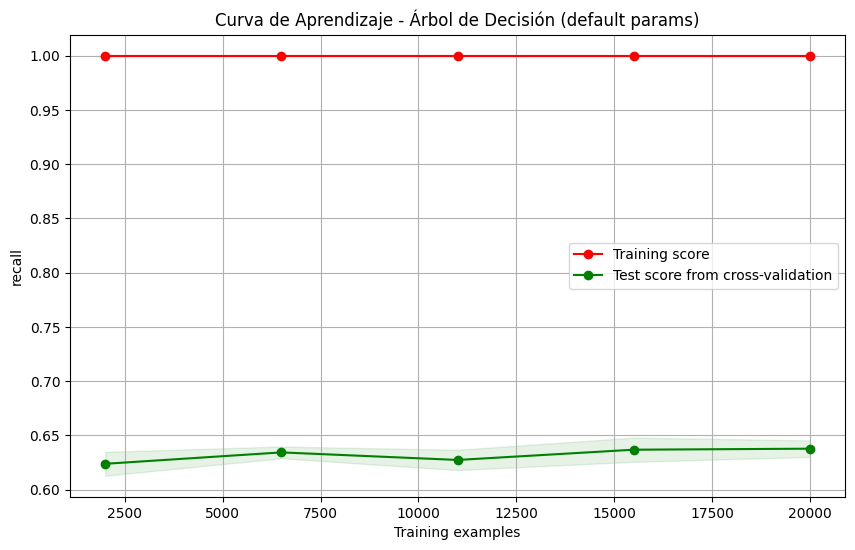

In [31]:
plot_learning_curve(model1, 'Curva de Aprendizaje - Árbol de Decisión (default params)', features, labels,  cv = cv1, scoring = 'recall');

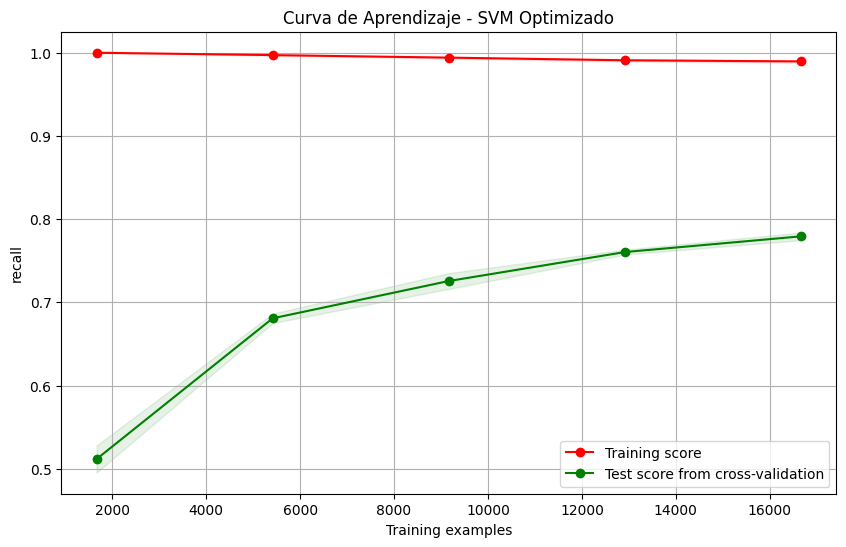

In [29]:
plot_learning_curve(bmodel2, 'Curva de Aprendizaje - SVM Optimizado', features, labels,  cv = cv3, scoring = 'recall');

**¿Qué otras consideraciones o limitaciones tenemos?**

Aquí es donde un analisi de las curvas de aprendizaje (learning curves) nos pueden dar información crucial.

 Gráfico 1: Curva de aprendizaje del Árbol de Decisión (model1)

 Gráfico 2: Curva de aprendizaje del SVM Optimizado (bmodel2)

(Nota: Tu código para el segundo gráfico tiene el título 'DT (default params)', pero la curva con un recall de ~0.78 corresponde a tu modelo SVM optimizado, bmodel2)

Estudiando los graficos notamos que ambos modelos muestran un sobreajuste (alta varianza). La línea de Training score (roja) está en 1.0 (o muy cerca), mientras que la línea de Test score (verde) está mucho más baja. Tambien podemos concluir que el modelo de arbol de decisión (Gráfico 1) es el peor caso: Su rendimiento en la validación cruzada se estanca muy rápido en ~0.64. Esto significa que el modelo esencialemente memorizó los datos y aumentarlos en cantidad no ayudarán con el rendimiento. Analiazando el otro caso, el SVM optimizado (Gráfico 2), es mucho más interesante. Aunque también está sobreajustado (linea roja), la línea verde que representa el Test score sigue en una tendencia ascendente. Esto significa que, a diferencia del Árbol de Decisión, aún puede mejorar y se beneficiaría de recibir más datos de entrenamiento.

Otra limitacion que podriamos pulir seria la búsqueda de hiperparámetros (GridSearch), la cual solo se realizó solo sobre el 5% de los datos para ahorrar tiempo. Si bien los parámetros encontrados funcionaron muy bien, es posible que una búsqueda sobre un conjunto de datos más grande (o sobre el 100% de los datos con validación cruzada) pudiera encontrar una combinación de parámetros aún mejor.